In [2]:
# 3ML
import os
os.environ["MKL_NUM_THREADS"] = '1'
os.environ["OMP_NUM_THREADS"] = '1'
os.environ["NUMEXPR_NUM_THREADS"] = '1'
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.utype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import threeML

# specific 3ML stuff
from astromodels import TemplateModelFactory
from astromodels import TemplateModel

# astropy
import astropy.units as u
import astropy.constants as const

# afterglowpy
import afterglowpy as ag

# calculate luminosity distances
import numpy as np
from scipy.integrate import quad
c = 3e10 # cm s^-1
H0 = 67.3 #km/sMpc
OmegaM = 0.315
OmegaLambda = 0.685
OmegaK = 0 # 1-OmegaM-OmegaLambda
dH = np.divide(c,H0)*1e-5 #answer in Mpc
Einv = lambda Z:np.divide(1,np.sqrt(OmegaM*(1+Z)**3+OmegaK*(1+Z)**2+OmegaLambda))
dL = lambda z:np.multiply((1+z),np.multiply(dH,quad(Einv,0,z)[0])) # obtain value in Mpc

# pandas
import pandas as pd

# optimization for Maximum likelihood
from scipy.optimize import minimize

# sampling and corner plots
import emcee
import pymc3 as pm
import ultranest as un
import pymultinest as mn
import corner
from ultranest.plot import cornerplot

# multiprocessing
from multiprocessing import Pool
import multiprocessing as mp

# plotting and utility
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
gr = 1.61803399
plt.style.use('default')
%matplotlib inline

# Model

### Plot example LC from afterglowpy

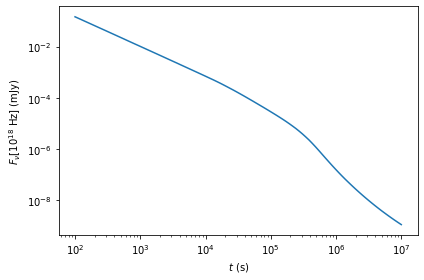

In [3]:
# For convenience, place arguments into a dict.
Z = {'jetType':     ag.jet.TopHat,     # Top-Hat jet
     'specType':    0,                  # Basic Synchrotron Emission Spectrum

     'thetaObs':    0.05,   # Viewing angle in radians
     'E0':          1.0e53, # Isotropic-equivalent energy in erg
     'thetaCore':   0.1,    # Half-opening angle in radians
     'n0':          1.0,    # circumburst density in cm^{-3}
     'p':           2.2,    # electron energy distribution index
     'epsilon_e':   0.1,    # epsilon_e
     'epsilon_B':   0.01,   # epsilon_B
     'xi_N':        1.0,    # Fraction of electrons accelerated
     'd_L':         1.0e28, # Luminosity distance in cm
     'z':           0.55}   # redshift

# Space time points geometrically, from 10^3 s to 10^7 s
t = np.geomspace(1.0e2, 1.0e7, 100)

# Calculate flux in a single X-ray band (all times have same frequency)
nu = np.empty(t.shape)
nu[:] = 1.0e18

# Calculate!
Fnu = ag.fluxDensity(t, nu, **Z)

fig, ax = plt.subplots(1, 1)

ax.plot(t, Fnu)

ax.set(xscale='log', xlabel=r'$t$ (s)',
       yscale='log', ylabel=r'$F_\nu$[$10^{18}$ Hz] (mJy)')

fig.tight_layout()


### Run test grid for afterglowpy and store results in array

In [4]:
E0 = [1.0e52,1.0e53,1.0e54]
epsilon_e = [0.01,0.03,0.1,0.3]
epsilon_B = [0.001,0.003,0.01,0.03]
z = [0.55]

# grid = [thetaObs,E0,thetaCore,n0,p,epsilon_e,epsilon_B,xi_N,d_L,z]
grid = [E0,epsilon_e,epsilon_B,z]

gridpoints = list(itertools.product(*grid))

# Space time points geometrically, from 10^3 s to 10^7 s
t_res = 50
t_low = 1.0e2
t_high = 1.0e7
t = np.geomspace(t_low, t_high, t_res)



for gp in gridpoints[:1]:
    
    E0,epsilon_e,epsilon_B,z = gp
    d_L = dL(z)*u.Mpc
    # span a grid:
    # For convenience, place arguments into a dict.
    Z = {'jetType':     ag.jet.TopHat,     # Top-Hat jet
         'specType':    0,                  # Basic Synchrotron Emission Spectrum

         'thetaObs':    0.05,   # Viewing angle in radians
         'E0':          E0, # Isotropic-equivalent energy in erg
         'thetaCore':   0.1,    # Half-opening angle in radians
         'n0':          1.0,    # circumburst density in cm^{-3}
         'p':           2.2,    # electron energy distribution index
         'epsilon_e':   epsilon_e,    # epsilon_e
         'epsilon_B':   epsilon_B,   # epsilon_B
         'xi_N':        1.0,    # Fraction of electrons accelerated
         'd_L':         d_L.to('cm').value, # Luminosity distance in cm
         'z':           z}   # redshift

    # calculate the spectrum over a large range of energies, for each time point
    nu_low = 1e0
    nu_high = 1e20
    nu_res = 30
    nu_vec = np.geomspace(nu_low,nu_high,nu_res)
    
    nu_matrix = np.empty((t_res,nu_res))

    for i,nu in enumerate(nu_vec):
        # Calculate!
        Fnu = ag.fluxDensity(t, nu, **Z)
        nu_matrix[:,i] = Fnu
    


#### plot LC

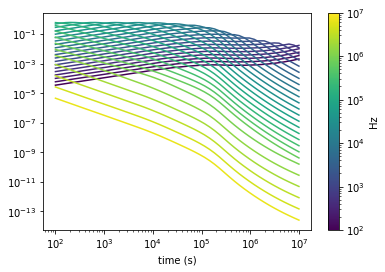

In [5]:
# plt.loglog(t,nu_matrix[:,-4])
colors = [cm.viridis((i)/nu_res) for i in range(nu_res)]

fig, ax = plt.subplots()
for i,nu_i in enumerate(nu_vec):
    pl = ax.loglog(t,nu_matrix[:,i],color=colors[i])
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=t[0], vmax=t[-1]) , cmap=cm.viridis))
cbar.ax.set_ylabel('Hz', rotation=90);
ax.set_xlabel('time (s)');
ax.set_ylabel('');

#### Plot spectrum

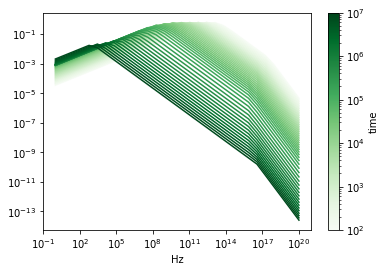

In [6]:
colors = [cm.Greens(i/t_res) for i in range(t_res)]

fig, ax = plt.subplots()
for i,t_i in enumerate(t):
    pl = ax.loglog(nu_vec,nu_matrix[i,:],color=colors[i])
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=t[0], vmax=t[-1]) , cmap=cm.Greens))
cbar.ax.set_ylabel('time', rotation=90);
ax.set_xlabel('Hz');
ax.set_ylabel('');

# Data

#### Perform the most naive of fits as an example. Here I fit only afterglow

In [4]:
fname = 'data_160625b.txt'
df = pd.read_csv(fname, sep='\s+', names=['time (d)', 'frequency (Hz)', 'flux (mJy)', 'error (mJy)'])
burst = fname.split('/')[-1].split('.')[0].split('_')[1]

In [5]:
df

,time (d),frequency (Hz),flux (mJy),error (mJy)
0,0.37,1.820000e+14,0.3370,0.00594
1,0.39,1.820000e+14,0.3240,0.00512
2,0.41,1.820000e+14,0.3170,0.00471
3,0.43,1.820000e+14,0.2860,0.00398
4,0.46,1.820000e+14,0.2850,0.00343
...,...,...,...,...
194,48.33,1.600000e+10,0.0970,0.02100
195,48.35,1.100000e+10,0.0950,0.02300
196,58.28,2.200000e+10,0.0520,0.01200
197,58.28,6.100000e+09,0.0750,0.01000


#### Plot data

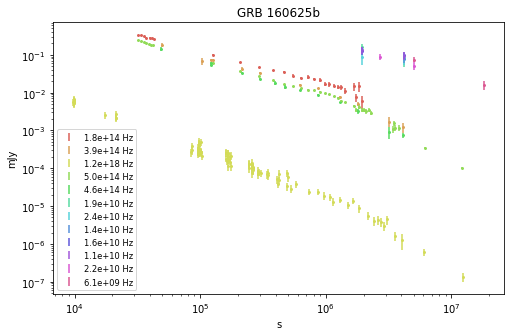

In [13]:
fs = 5
fig, ax = plt.subplots(figsize = (fs*gr,fs))
colors = sns.color_palette("hls", n_colors = len(df['frequency (Hz)'].unique()))

for i,freq in enumerate(df['frequency (Hz)'].unique()):
    df_i = df.loc[df['frequency (Hz)']==freq]
    x = df_i['time (d)'].values * u.d
    y = df_i['flux (mJy)'].values * u.mJy
    yerr = df_i['error (mJy)'].values * u.mJy
    # convert to other units
    x = x.to('s')
#     y = y.to('W/(m2 Hz)')
#     yerr = yerr.to('W/(m2 Hz)')
    ax.errorbar(x.value,y.value,yerr=yerr.value,ls='',lw=1.5,color=colors[i],label=f'{freq:.1e} Hz')
    ax.scatter(x.value,y.value,marker='.',s=15,color=colors[i])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'{x.unit}')
ax.set_ylabel(f'{y.unit}')
ax.set_title(f'GRB {burst}')
ax.legend(fontsize='small');

### Fit afterglowpy

#### Put data into an appropriate format

In [6]:
fname = os.path.join(DataPath_afterglow,'data_160625b.txt')
df = pd.read_csv(fname, sep='\s+', names=['time (d)', 'frequency (Hz)', 'flux (mJy)', 'error (mJy)'])
burst = fname.split('/')[-1].split('.')[0].split('_')[1]

d = df['flux (mJy)'].values * u.mJy
d = d.to('mJy').value
sigma_d = df['error (mJy)'].values * u.mJy
sigma_d = sigma_d.to('mJy').value

t = df['time (d)'].values * u.d
t = t.to('s').value
nu = df['frequency (Hz)'].values * u.Hz
nu = nu.to('Hz').value

data = np.array([d,sigma_d,t,nu])

#### Define likelihood

In [7]:
z = 1
d_L = dL(z)*u.Mpc
d_L = d_L.to('cm').value
p = 2.2
epsilon_B = 0.1
epsilon_e = 0.01

# 1D

def g_1D(pars,t_i,nu_i):
    E0 = pars[0]
    E0 = 10**float(E0)
    Z = {'jetType':     ag.jet.TopHat,     # Top-Hat jet
         'specType':    0,                  # Basic Synchrotron Emission Spectrum

         'thetaObs':    0.05,   # Viewing angle in radians
         'E0':          E0,     # Isotropic-equivalent energy in erg
         'thetaCore':   0.1,    # Half-opening angle in radians
         'n0':          1.0,    # circumburst density in cm^{-3}
         'p':           p,      # electron energy distribution index
         'epsilon_e':   epsilon_e,    # epsilon_e
         'epsilon_B':   epsilon_B,   # epsilon_B
         'xi_N':        1.0,    # Fraction of electrons accelerated
         'd_L':         d_L,    # Luminosity distance in cm
         'z':           z}      # redshift
    
    Fnu = ag.fluxDensity(t_i, nu_i, **Z)*u.mJy #*u.Unit('W Hz-1 m-2')
    return Fnu.to('mJy').value
    
def log_like_1D(pars):
    d,sigma_d,t,nu = data
    return -0.5*np.sum( (d - g_1D(pars,t,nu))**2/(2*sigma_d**2) )

# 4D

def g_4D(pars,t_i,nu_i):
    E0,p,epsilon_e,epsilon_B = pars
    E0 = 10**float(E0)
    Z = {'jetType':     ag.jet.TopHat,     # Top-Hat jet
         'specType':    0,                  # Basic Synchrotron Emission Spectrum

         'thetaObs':    0.05,   # Viewing angle in radians
         'E0':          E0,     # Isotropic-equivalent energy in erg
         'thetaCore':   0.1,    # Half-opening angle in radians
         'n0':          1.0,    # circumburst density in cm^{-3}
         'p':           p,      # electron energy distribution index
         'epsilon_e':   epsilon_e,    # epsilon_e
         'epsilon_B':   epsilon_B,   # epsilon_B
         'xi_N':        1.0,    # Fraction of electrons accelerated
         'd_L':         d_L,    # Luminosity distance in cm
         'z':           z}      # redshift
    
    Fnu = ag.fluxDensity(t_i, nu_i, **Z)*u.mJy #*u.Unit('W Hz-1 m-2')
    return Fnu.to('mJy').value
    
def log_like_4D(pars):
    d,sigma_d,t,nu = data
    return -0.5*np.sum( (d - g_4D(pars,t,nu))**2/(2*sigma_d**2) )

##### check likelihood function in 1D

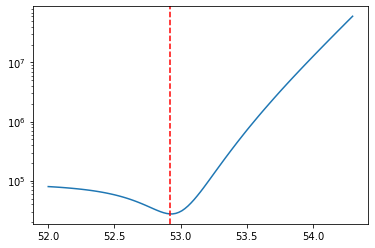

In [19]:
E0 = 50
p = 2.2
epsilon_e = 0.1
epsilon_B = 0.01

lvec = []
e0vec = np.geomspace(52,54.3,100)
for E0 in e0vec:
#     pars = [E0,p,epsilon_e,epsilon_B]
    pars = [E0]
    res = -2*log_like_1D(pars)
#     print(f'-2ln(L) = {res:.2e}')
#     print(f'E0 = {E0:10.2f}')
#     print('---')
    lvec.append(res)

plt.plot(e0vec,lvec)
plt.yscale('log')
plt.axvline(52.92,color='r',ls='--')

Okay, so there appears to be a minimum somewhere around 52.9

### minimize likelihood to find best fit

#### Try two different optimization schemes

##### Powell

In [21]:
np.random.seed(12)
nll = lambda *args: -2*log_like_1D(*args)
# initial = np.array([52,2.5,0.1,0.01])
initial = np.array([52])
soln = minimize(nll, initial, method='Powell',
                bounds = ((51,55), ))
#                 bounds = ((51,55), (2.0001,3), (0,1), (0,1)))
                
res = soln.x
print(res)

[52.92793438]


##### Trust-constr

In [23]:
np.random.seed(12)
nll = lambda *args: -log_like_1D(*args)
# initial = np.array([52,2.5,0.1,0.01])
initial = np.array([52])
soln = minimize(nll, initial, method='trust-constr',
                bounds = ((51,55), ))
#                 bounds = ((51,55), (2.0001,3), (0,1), (0,1)))
                
res = soln.x
print(res)

[52.92823574]


Clearly, these yield quite different answers when using four free parameters. They do agree if I limit the parameter space to E0, which is expected. I believe some tweaking would resolve the discrepancy in >1D and that a stable and reliable fit is possible. I will note that I believe more in the Powell fit, since the trust-constr fit is on the boundary of the parameter space.

However, since ML is not the purpose here, I move on to emcee.

### EMCEE

### Define priors and obtain posterior

#### priors

In [8]:
def log_uniform_prior(x,lb,ub):
    if lb < x < ub:
        return 1/x
    else:
        return 0
    
def uniform_prior(x,lb,ub):
    if lb < x < ub:
        return 1/(ub - lb)
    else:
        return 0
    
def log_prior_1D(pars):
    E0 = pars[0]
    prior = uniform_prior(E0,lb=50,ub=55)
    if prior==0:
        return -np.inf
    return np.log(prior)

def log_probability_1D(pars):
    lp = log_prior_1D(pars)
    if not np.isfinite(lp):
        return -np.inf
    log_posterior = lp + log_like_1D(pars)
    return log_posterior


def log_prior_4D(pars):
    E0,p,epsilon_e,epsilon_B = pars
    prior = uniform_prior(E0,lb=50,ub=55) * uniform_prior(p,lb=2,ub=3) * uniform_prior(epsilon_e,lb=0,ub=1) * uniform_prior(epsilon_B,lb=0,ub=0.1)
    if prior==0:
        return -np.inf
    return np.log(prior)

def log_probability_4D(pars):
    lp = log_prior_4D(pars)
    if not np.isfinite(lp):
        return -np.inf
    log_posterior = lp + log_like_4D(pars)
    return log_posterior

### emcee


#### 1D

In [26]:
nwalkers = 30
pos = np.array([53]) + np.hstack([np.random.uniform(-1,1,(nwalkers, 1))])

nwalkers, ndim = pos.shape

with Pool(12) as pool:

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_1D,
#                                    moves=[(emcee.moves.KDEMove(), 0.1), (emcee.moves.DESnookerMove(), 0.2), (emcee.moves.DEMove(),0.7)],
                                   pool=pool)
    sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [13:04<00:00,  6.37it/s]


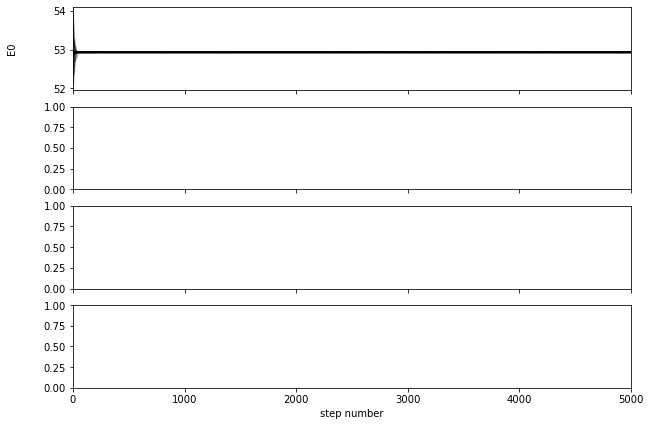

In [27]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["E0", "p", "e_e","e_b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [28]:
tau = sampler.get_autocorr_time()
print(tau)

[14.78387153]


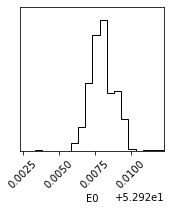

In [29]:
flat_samples = sampler.get_chain(discard=1000, thin=int(tau/2), flat=True)

fig = corner.corner(flat_samples, labels=labels);

#### 4D

In [405]:
nwalkers = 50
pos = np.array([53,2.1,0.2,0.025]) + np.hstack([np.random.uniform(-1,1,(nwalkers, 1)),
                                               np.random.uniform(-0.09,0.8,(nwalkers, 1)), 
                                               np.random.uniform(-0.19,0.79,(nwalkers, 1)), 
                                               np.random.uniform(-0.024,0.074,(nwalkers, 1))])

nwalkers, ndim = pos.shape

with Pool(12) as pool:

    sampler_4D = emcee.EnsembleSampler(nwalkers, ndim, log_probability_4D,
#                                    moves=[(emcee.moves.KDEMove(), 0.1), (emcee.moves.DESnookerMove(), 0.2), (emcee.moves.DEMove(),0.7)],
                                   pool=pool)
    sampler_4D.run_mcmc(pos, 5000, progress=True);
    


100%|██████████| 5000/5000 [11:52<00:00,  7.02it/s]


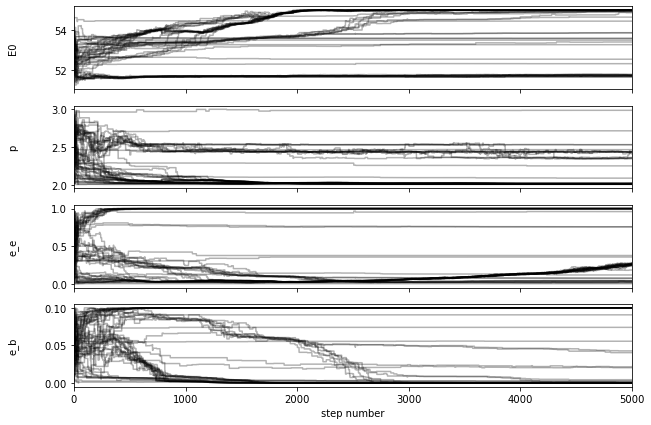

In [406]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples_4D = sampler_4D.get_chain()
labels = ["E0", "p", "e_e","e_b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_4D[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_4D))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [407]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [599.31124199 494.79802567 523.66602077 520.90783969]

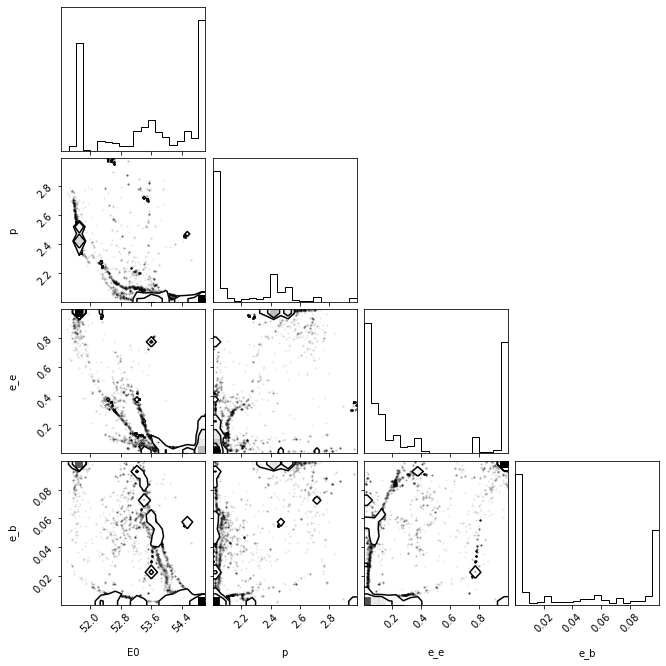

In [408]:
flat_samples_4D = sampler_4D.get_chain(discard=1000, thin=int(tau/2), flat=True)

fig = corner.corner(flat_samples_4D, labels=labels);